In [1]:
import numpy as np
import pandas as pd
import pickle
import torch
import sys
import matplotlib.pyplot as plt
from matplotlib import cm,colors
from warnings import filterwarnings
from tqdm import tqdm
import seaborn as sns
import scanpy as sc
import glob

### Gather performance and plotting

In [2]:
# load in data
dataset = 'replogle_k562_essential'
use_hvg = True
dataset_name = dataset + ('_hvg' if use_hvg else '_full')
test_set_id = 'random_fold_4'
random_seed = 12
null_label = 'zeros' # 'gaussian_normalized' or 'zeros'
tolerance_epoch = 20
prior = 'DepMap_GeneEffect'
latdim_ctrl = 50
latdim_ptb = 50
geneset_num = 50
val_ratio = 0.1
val_ood_ratio = 0.15
model_type = 'mvae_attention_vae_14_3'

In [3]:
import os
savedir = f'./{dataset_name}/{test_set_id}/null_label_{null_label}/prior_{prior}/tolerance_epoch_{tolerance_epoch}/'

if not os.path.exists(savedir):
    os.makedirs(savedir)

In [4]:
adata_file_path = '/home/che/perturb-project/git/gene_ptb_prediction/scdata_file_path.csv'
adata_file = pd.read_csv(adata_file_path)
adata_path = adata_file[(adata_file['dataset'] == dataset) & (adata_file['use_hvg'] == use_hvg)]['file_path'].values[0]
adata = sc.read(adata_path)
print('Read adata from', adata_path)

/home/che/anaconda3/envs/geneformer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


Read adata from /home/che/perturb-project/predict_model/dataset/replogle_k562/K562_essential_normalized_hvg.h5ad


### Step 1. Read in data

In [5]:
gears_path = f'/home/che/GEARS/{dataset_name}/{test_set_id}/random_seed_{random_seed}/gears_pred_dict.pkl'
gears_pred_dict = pickle.load(open(gears_path, 'rb'))

In [6]:
vae_attention_path = f'/home/che/perturb-project/predict_model/result/rna/{dataset_name}/latdim_ctrl_{latdim_ctrl}_latdim_ptb_{latdim_ptb}_geneset_num_{geneset_num}'
vae_attention_path_parent_temp = f'{vae_attention_path}/{test_set_id}/recon_loss_mmd/null_label_{null_label}/epochs_100/tolerance_epochs_{tolerance_epoch}/mxAlpha_2.0/val_{val_ratio}_ood_{val_ood_ratio}/random_seed_{random_seed}'
pattern = f'{vae_attention_path_parent_temp}/{prior}_{model_type}_run*'
vae_attention_path_temp = glob.glob(pattern)
assert len(vae_attention_path_temp) == 1, f'Error: {pattern}'
vae_attention_path_temp = vae_attention_path_temp[0]
vae_pred_dict = pickle.load(open(f'{vae_attention_path_temp}/best_model_pred_test.pkl', 'rb'))
summary_eval = pd.read_csv(f'{vae_attention_path_temp}/best_model_evaluations.csv')

In [7]:
# read in change from control
if dataset == 'replogle_k562_essential':
    change_df = pd.read_csv(f'/home/che/perturb-project/predict_model/dataset/replogle_k562/replogle_k562_essential_hvg_mmd_distance_1500_to_non-targeting.csv')
elif dataset == 'replogle_rpe1':
    change_df = pd.read_csv(f'/home/che/perturb-project/predict_model/dataset/{dataset}/{dataset_name}_mmd_distance_to_non-targeting.csv')
change_df = change_df[['ptb_gene', 'mean_mmd_distance', 'data_size']]

# merge with sumary_eval
summary_eval = summary_eval.merge(change_df, left_on='pert', right_on='ptb_gene', how='left')

In [8]:
summary_eval.sort_values('mean_mmd_distance', ascending=False, inplace=True)
# summary_eval[summary_eval['mmd'] < 0.5].head(10)
top_n = 30
summary_eval = summary_eval.head(top_n)
summary_eval.to_csv(f'{savedir}/summary_eval.csv', index=False)
summary_eval

,pert,mmd,rmse,mse,r2,pearsonr,rmse_change,pearsonr_change,fraction,ptb_gene,mean_mmd_distance,data_size
337,MED9,0.685702,0.308941,0.095444,0.958503,0.988850,0.308941,0.961121,0.96,MED9,0.691861,96
23,SUPT5H,1.074164,0.482587,0.232891,0.884131,0.970896,0.482587,0.840712,0.98,SUPT5H,0.681007,384
14,INTS2,1.872965,0.677457,0.458949,0.712833,0.846684,0.677457,0.870320,0.96,INTS2,0.676450,352
116,HSPA9,1.781500,0.724594,0.525037,0.729862,0.866782,0.724594,0.758166,0.90,HSPA9,0.636578,416
266,SARS,0.709804,0.108337,0.011737,0.000000,NaN,0.108337,0.132096,0.48,SARS,0.582141,32
33,RPL17,0.618194,0.274384,0.075286,0.945113,0.975889,0.274384,0.984236,1.00,RPL17,0.575809,128
310,POLR2H,0.835355,0.404718,0.163797,0.917750,0.972687,0.404718,0.777805,0.96,POLR2H,0.573027,96
260,CDK7,0.759096,0.125436,0.015734,0.000000,NaN,0.125436,0.000104,0.42,CDK7,0.562554,32
168,TAF1,1.040884,0.433236,0.187693,0.910705,0.956154,0.433236,0.931071,0.96,TAF1,0.550774,96
243,CTR9,0.947633,0.387038,0.149799,0.922650,0.972532,0.387038,0.931026,0.98,CTR9,0.543229,192


### Step 2. Subset to check UMAP

In [9]:
# test_check_list = top_df['pert'].unique().tolist()
test_check_list = summary_eval['pert'].tolist()
print('test_check_list:', test_check_list)
print('length of test_check_list:', len(test_check_list))

test_check_list: ['MED9', 'SUPT5H', 'INTS2', 'HSPA9', 'SARS', 'RPL17', 'POLR2H', 'CDK7', 'TAF1', 'CTR9', 'MED6', 'EXOSC4', 'OR4K1', 'EXOC8', 'PLRG1', 'PPWD1', 'POLR2I', 'CPSF4', 'CNOT1', 'SFPQ', 'RPL36', 'UTP3', 'SRRT', 'PSMC4', 'RPS3', 'DDX41', 'TAF2', 'RPL26', 'MED11', 'RPS27A']
length of test_check_list: 30


In [10]:
np.random.seed(random_seed)
true_y_gene_expressions = {}
vae_expressions= {}
gears_expressions = {}

for pert_name in tqdm(test_check_list):
    # print('Pert name', pert_name)

    true_y = adata[adata.obs['gene'] == pert_name].X

    pred_y_vae = vae_pred_dict[pert_name]
    pred_gears = gears_pred_dict[pert_name+'+ctrl' if '+' not in pert_name else pert_name]

    # get min of sample size
    min_sample_size = min(
                          true_y.shape[0],
                          pred_y_vae.shape[0],
                          pred_gears.shape[0])
    # print('Min sample size', min_sample_size)

    # random sample from all predictions to make same size
    true_y = true_y[np.random.choice(true_y.shape[0], min_sample_size, replace=False),:]
    pred_y_vae = pred_y_vae[np.random.choice(pred_y_vae.shape[0], min_sample_size, replace=False),:]
    pred_gears = pred_gears[np.random.choice(pred_gears.shape[0], min_sample_size, replace=False),:]

    assert true_y.shape[0] == pred_y_vae.shape[0] == pred_gears.shape[0], 'Error: sample size not match'

    true_y_gene_expressions[pert_name] = true_y
    vae_expressions[pert_name] = pred_y_vae
    gears_expressions[pert_name] = pred_gears
    

100%|██████████| 30/30 [00:00<00:00, 174.40it/s]


### 3. UMAP

In [11]:
adata_ctrl = adata[adata.obs['gene'] == 'non-targeting'].copy()
ctrl_X = adata_ctrl.X

all_data = np.vstack([ctrl_X, 
                      np.vstack(list(true_y_gene_expressions.values())),
                      np.vstack(list(vae_expressions.values())),
                      np.vstack(list(gears_expressions.values()))
                    #   np.vstack(list(scgpt_gene_expression.values()))
                    ])
                      

adata_new = sc.AnnData(all_data)
adata_new

AnnData object with n_obs × n_vars = 25667 × 5000

In [12]:
# Assign labels for each model in adata_new.obs
adata_new.obs['model'] = (
    ['Control cells'] * ctrl_X.shape[0] +
    ['Perturbed cells'] * np.vstack(list(true_y_gene_expressions.values())).shape[0] +
    ['VAE (DepMap)'] * np.vstack(list(vae_expressions.values())).shape[0] +
    ['Gears'] * np.vstack(list(gears_expressions.values())).shape[0]
)
adata_new

AnnData object with n_obs × n_vars = 25667 × 5000
    obs: 'model'

In [13]:
# Create the 'gene' column by repeating each key in `true_y_gene_expressions` by the count of its entries
gene_labels = ['non-targeting'] * ctrl_X.shape[0]
for gene, expression_data in true_y_gene_expressions.items():
    gene_labels.extend([gene] * expression_data.shape[0])

for gene, expression_data in vae_expressions.items():
    gene_labels.extend([gene] * expression_data.shape[0])

for gene, expression_data in gears_expressions.items():
    gene_labels.extend([gene] * expression_data.shape[0])

# Assign gene labels to adata_new.obs['gene']
adata_new.obs['gene'] = gene_labels
adata_new

AnnData object with n_obs × n_vars = 25667 × 5000
    obs: 'model', 'gene'

In [14]:
# calculate PCA and UMAP
np.random.seed(random_seed)
sc.settings.seed = random_seed  # Set seed for scanpy
sc.tl.pca(adata_new, svd_solver='arpack')
sc.pp.neighbors(adata_new, n_neighbors=30, n_pcs=50)
sc.tl.umap(adata_new, min_dist=0.3)

/home/che/anaconda3/envs/geneformer/lib/python3.10/site-packages/pynndescent/pynndescent_.py:346: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/deprecation.html#deprecation-of-old-style-numba-captured-errors
Exception origin:
  File "/home/che/anaconda3/envs/geneformer/lib/python3.10/site-packages/numba/core/types/functions.py", line 486, in __getnewargs__
    raise ReferenceError("underlying object has vanished")

  init_rp_tree(data, dist, current_graph, leaf_array)
/home/che/anaconda3/envs/geneformer/lib/python3.10/site-packages/pynndescent/pynndescent_.py:348: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readth

In [15]:
# save the adata_new
adata_new.write(f'{savedir}/adata_umap.h5ad')
print('Saved adata_new to', f'{savedir}/adata_umap.h5ad')

Saved adata_new to ./replogle_k562_essential_hvg/random_fold_4/null_label_zeros/prior_DepMap_GeneEffect/tolerance_epoch_20//adata_umap.h5ad


/tmp/ipykernel_24386/78351659.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model = adata_new.obs['model'][idx]


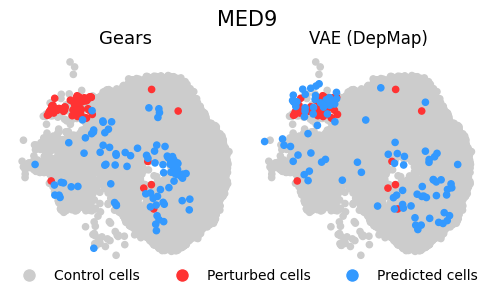

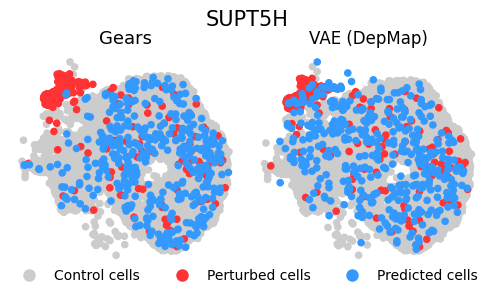

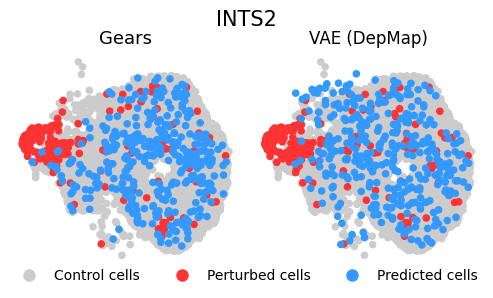

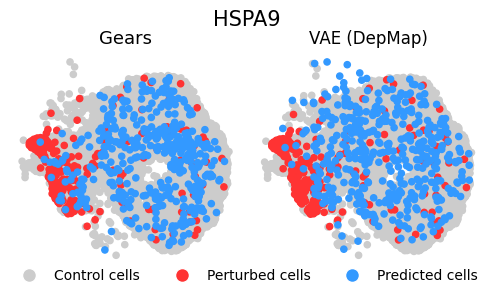

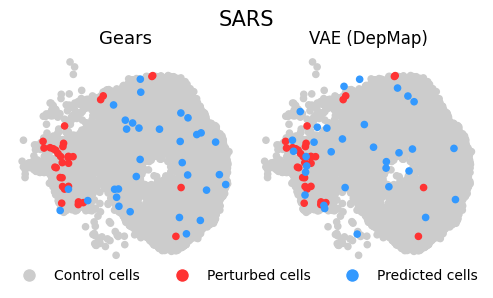

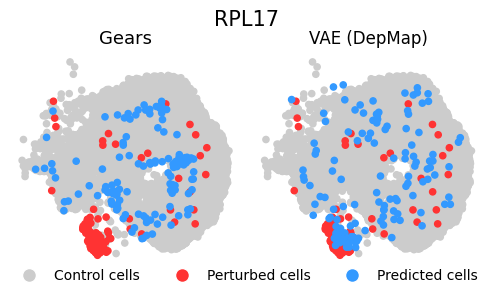

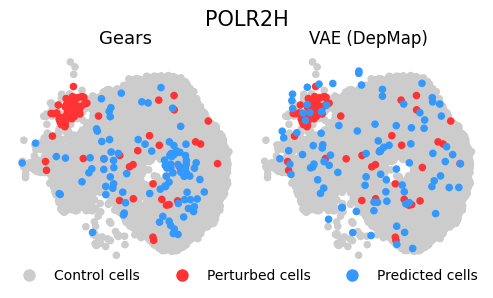

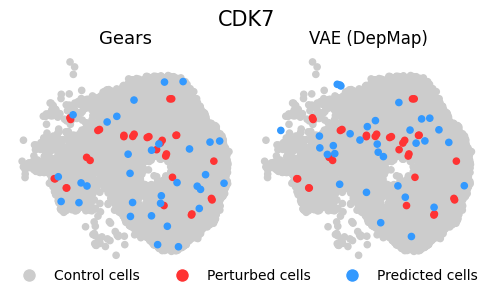

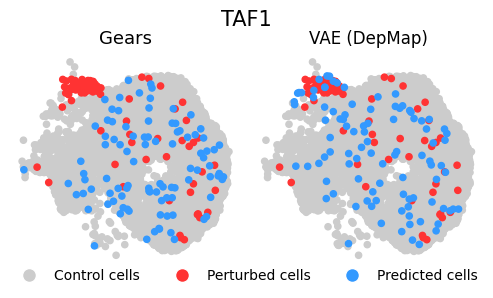

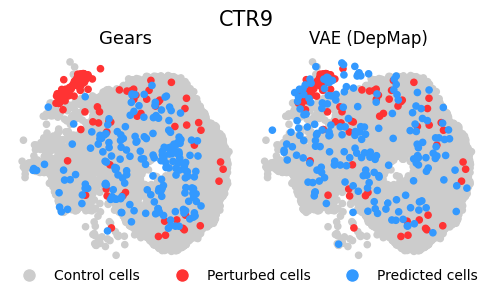

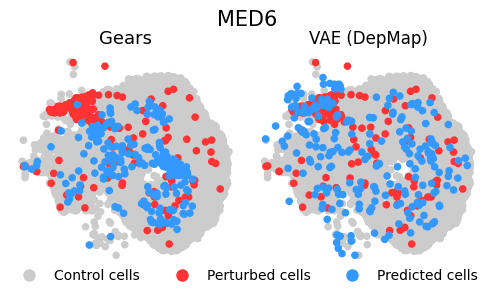

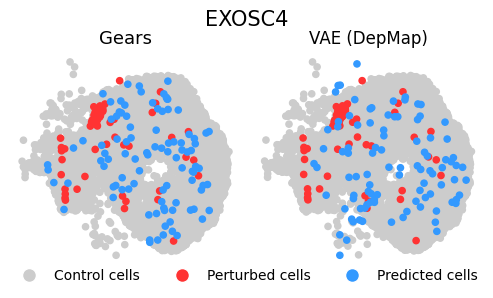

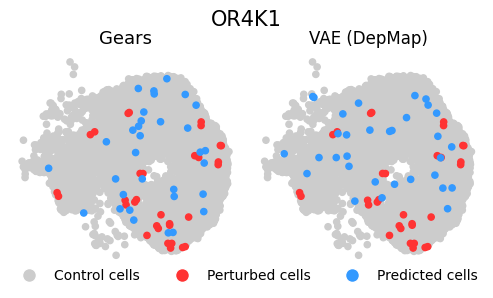

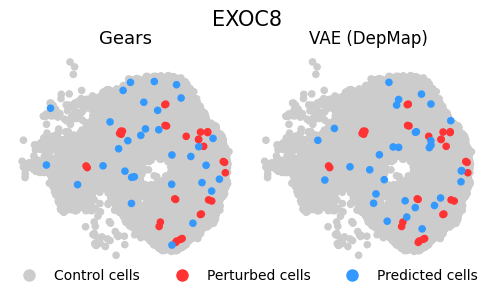

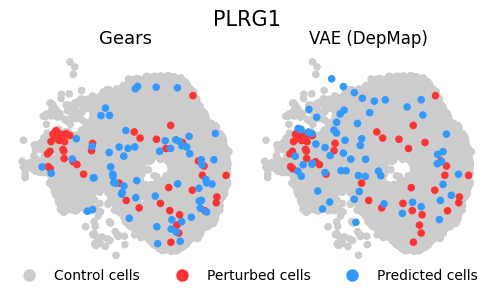

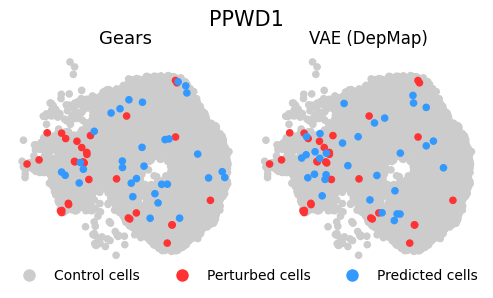

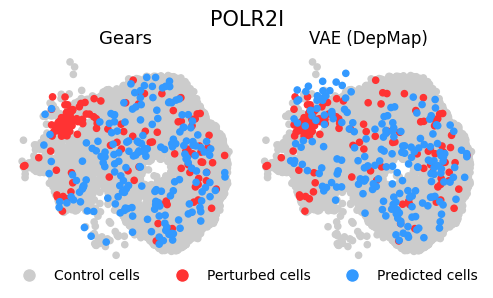

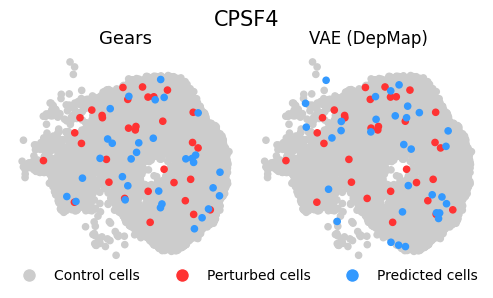

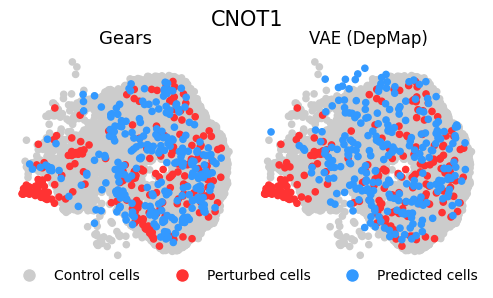

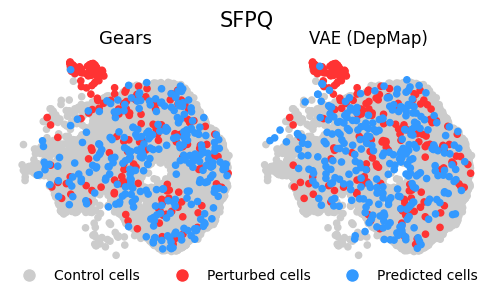

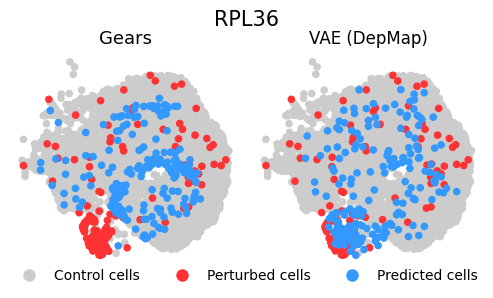

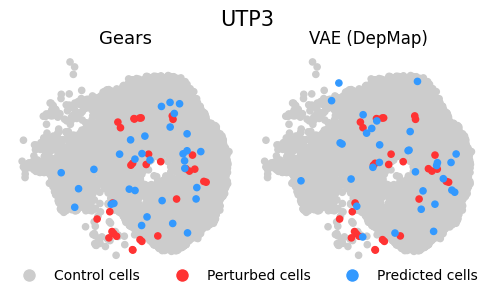

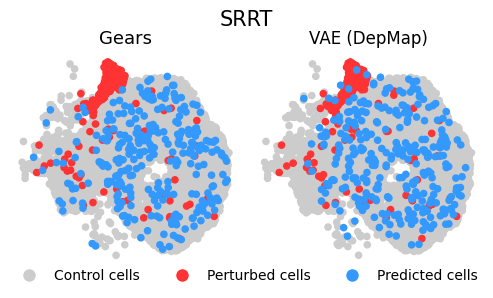

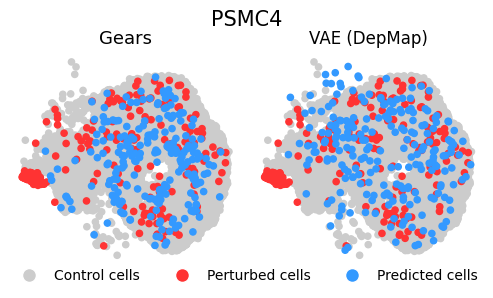

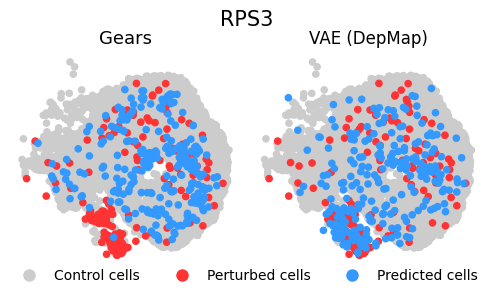

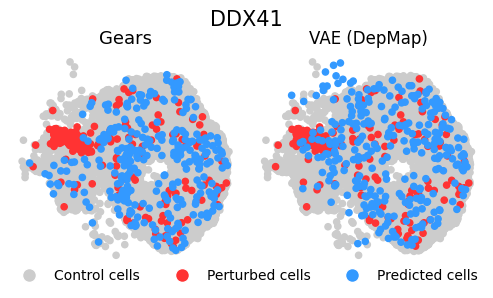

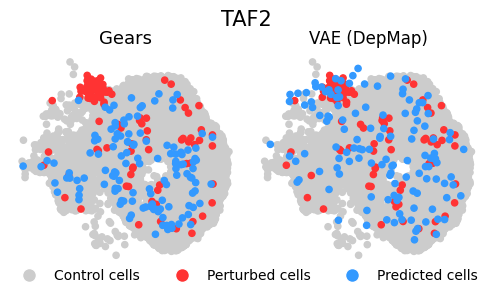

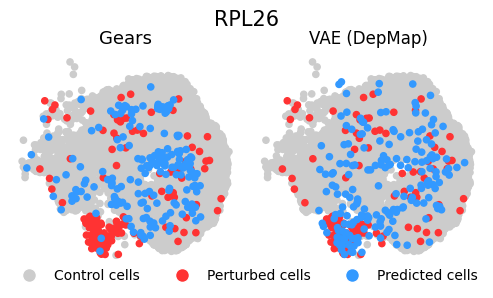

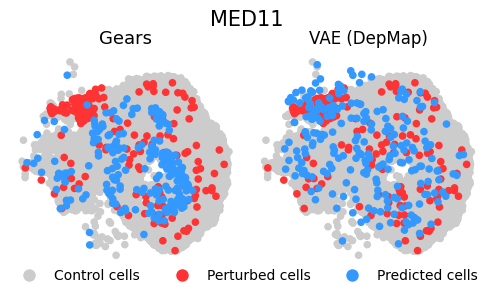

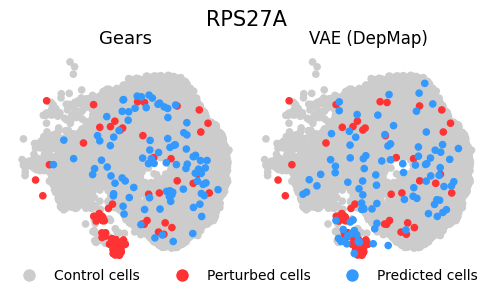

In [16]:
import matplotlib.pyplot as plt
import scanpy as sc

# Get unique perturbations and remove control label
perturbations = adata_new.obs['gene'].unique().tolist()
perturbations.remove('non-targeting')  

# Loop through each perturbation to create side-by-side UMAP plots for Gears and VAE
for perturbation in perturbations:
    fig, axs = plt.subplots(1, 2, figsize=(5, 3))  # Two side-by-side subplots

    # Define color maps for Gears and VAE
    color_map_gears = []
    color_map_vae = []

    for idx, gene in enumerate(adata_new.obs['gene']):
        if gene == 'non-targeting':
            color_map_gears.append('#cccccc')  # Control cells
            color_map_vae.append('#cccccc')    # Control cells
        elif gene == perturbation:
            model = adata_new.obs['model'][idx]
            if model == 'Perturbed cells':
                color_map_gears.append('#FF3333')    # True cells
                color_map_vae.append('#FF3333')      # True cells
            elif model == 'Gears':
                color_map_gears.append('#3399FF')  # Predicted cells of Gears (blue)
                color_map_vae.append((0, 0, 0, 0)) # Transparent for VAE
            elif model == 'VAE (DepMap)':
                color_map_gears.append((0, 0, 0, 0)) # Transparent for Gears
                color_map_vae.append('#3399FF')  # Predicted cells of VAE (green)
        else:
            color_map_gears.append((0, 0, 0, 0))  # Other perturbations, transparent
            color_map_vae.append((0, 0, 0, 0))    # Other perturbations, transparent

    # Plot UMAP for Gears
    # sc.pl.umap(adata_new, color=None, show=False, ax=axs[0])
    # axs[0].scatter(adata_new.obsm['X_umap'][:, 0], adata_new.obsm['X_umap'][:, 1], c=color_map_gears, s=10)
    # Filter out transparent points for Gears
    x_gears = adata_new.obsm['X_umap'][[color != (0, 0, 0, 0) for color in color_map_gears], 0]
    y_gears = adata_new.obsm['X_umap'][[color != (0, 0, 0, 0) for color in color_map_gears], 1]
    colors_gears = [color for color in color_map_gears if color != (0, 0, 0, 0)]
    axs[0].scatter(x_gears, y_gears, c=colors_gears, s=20)
    axs[0].set_title(f"Gears", fontsize=13, color='black')
    axs[0].axis('off')


    # Plot UMAP for VAE
    # sc.pl.umap(adata_new, color=None, show=False, ax=axs[1])
    # axs[1].scatter(adata_new.obsm['X_umap'][:, 0], adata_new.obsm['X_umap'][:, 1], c=color_map_vae, s=10)
    # Filter out transparent points for VAE
    x_vae = adata_new.obsm['X_umap'][[color != (0, 0, 0, 0) for color in color_map_vae], 0]
    y_vae = adata_new.obsm['X_umap'][[color != (0, 0, 0, 0) for color in color_map_vae], 1]
    colors_vae = [color for color in color_map_vae if color != (0, 0, 0, 0)]
    axs[1].scatter(x_vae, y_vae, c=colors_vae, s=20)
    axs[1].set_title(f"VAE (DepMap)", fontsize=12, color='black')
    axs[1].axis('off')

    fig.suptitle(f'{perturbation}', fontsize=15, y=0.9, color='black')

    # Add a legend below the super title
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#CCCCCC', markersize=10, label='Control cells'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#FF3333', markersize=10, label='Perturbed cells'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#3399FF', markersize=10, label='Predicted cells')
    ]
    fig.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3, frameon=False, fontsize=10, labelcolor='black')
    plt.tight_layout()
    plt.savefig(f'{savedir}/{perturbation}.svg', format='svg')
    plt.show()